In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [28]:
Nstep = 38
length = 40
ratio = 0.6
def data_handler_VAR(data, max_length = length):
    for line in range(len(data)):
        tmp = data[line]
        l = len(tmp)
        if l < max_length:
            for i in range(max_length-l):
                tmp.append(data[line][-1])
        else:
            tmp = tmp[:max_length]
        data[line] = tmp
        
    train = None
    label = None
    N = Nstep
    for row in range(len(data)):
        for i in range(N, len(data[row])):
            vec = None
            for j in range(i-N, i):
                tmp = (np.array([round(data[row][j][0]), round(data[row][j][1])]).T).reshape((2,1))
                if vec is None: 
                    vec = tmp
                else:
                    vec = np.vstack((vec, tmp))
                    
            tmp1 = (np.array([round(data[row][i][0]), round(data[row][i][1])]).T).reshape((2,1))
            if label is None:
                label = tmp1
            else:
                label = np.hstack((label, tmp1))
                
            if train is None:
                train = vec
            else:
                train = np.hstack((train, vec))
    train = np.vstack((train, np.ones((1, train.shape[1]))))
    return train, label

def read_human(path='Mousecollector/records1.txt', return_original = False):
    train = pd.read_csv(path, sep=' ', header=None, encoding='utf-8', names=['data'])
    data = train['data'].apply(lambda x: [list(map(float, point.split(','))) for point in x.split(';')])
    if return_original:
        return data[:int(len(data)*(1-ratio))]
    else:
        return data_handler_VAR(data[:int(len(data)*ratio)])

def read_bot(path='data/gc.csv', return_original = False):
    train = pd.read_csv(path, sep=' ', header=None, encoding='utf-8', names=['id','data','_','1','end'])
    data = train['data'].apply(lambda x: [list(map(float, point.split(';'))) for idx, point in enumerate(x.split(',')) if idx % 2 == 0][2:-2])
    if return_original:
        return data[:int(len(data)*(1-ratio))]
    else:
        return data_handler_VAR(data[:int(len(data)*ratio)])

In [29]:
train_bot, label_bot = read_bot()
print(train_bot.shape)

(77, 120)


In [30]:
train_human, label_human = read_human()
print(train_human.shape)

(77, 360)


In [289]:
import numpy.linalg as la
import scipy.linalg as spla

trains = [train_human, train_bot]
labels = [label_human, label_bot]

As = []
for i in range(len(trains)):
    new_train, new_label = trains[i], labels[i]
    A = new_train.T
    b = new_label
    Q, R = la.qr(A)
    x = spla.solve_triangular(R, Q.T.dot(b.T), lower=False)
    print(la.norm(A.dot(x)-b.T, 2))
    print(x.shape)
    As.append(x)
len(As)

5.921873275650935
(77, 2)
4.215105957784848
(77, 2)


2

In [290]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [323]:
# predicting training data
def predict(data, As, N=Nstep, max_length=length):
    pred_label = []
    for line in range(len(data)):
        tmp = data[line]
        l = len(tmp)
        if l < max_length:
            for i in range(max_length-l):
                tmp.append(data[line][-1])
        else:
            tmp = tmp[:max_length]
        data[line] = tmp
        
    for row in range(len(data)):
        for i in range(N, len(data[row])):
            vec = None
            for j in range(i-N, i):
                tmp = (np.array([round(data[row][j][0]), round(data[row][j][1])]).T).reshape((2,1))
                if vec is None: 
                    vec = tmp
                else:
                    vec = np.vstack((vec, tmp))
                    
            vec = np.vstack((vec, np.ones((1, vec.shape[1]))))
            label = (np.array([round(data[row][i][0]), round(data[row][i][1])]).T).reshape((2,1))
            res = []
            for A in As:
                res.append(la.norm(vec.T.dot(A)-label.T, 2))
            min_score = float("inf")
            idx = -1
            for i in range(len(res)):
                if min_score > res[i]:
                    min_score = res[i]
                    idx = i
            pred_label.append(idx)
    return pred_label

In [292]:
def confusion(data, As):
    pred_labels = []
    real_labels = []
    for i in range(len(data)):
        tmp = predict(data[i], As)
        pred_labels += tmp
        real_labels += [i]*len(tmp)
        print(len(tmp))
    cm = confusion_matrix(real_labels, pred_labels)
    classes = ['human', 'bot']
    plt.figure()
    plot_confusion_matrix(cm, classes=classes, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [293]:
dtest = [read_human(return_original=True), read_bot(return_original=True)]

160
80
Normalized confusion matrix


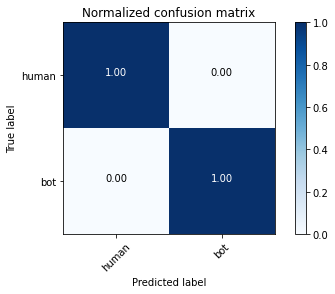

In [294]:
confusion(dtest, As)

In [334]:
# testing on the old 3000 data entries
def read_data(path='data/dsjtzs_txfz_training.txt'):
    train = pd.read_csv(path, sep=' ', header=None, encoding='utf-8', names=['id', 'data', 'target', 'label'])
    data = train['data'].apply(lambda x: [list(map(float, point.split(',')))[:-1] for point in x.split(';')[:-1]])
    label = list(train['label'])
    
    sep = label.index(0)
    human = data[:sep]
    bot = list(data[sep:])
    return human, bot

5200
800
Normalized confusion matrix


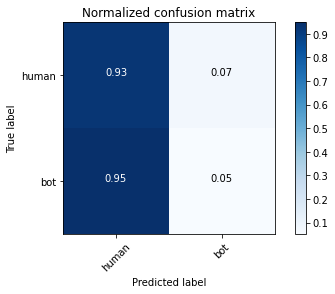

In [335]:
human, bot = read_data()
dtest1 = [human, bot]
confusion(dtest1, As)